# Optimization in Machine Learning (Winter 2020)
# Assignment 2

Yitian Zhang

yitian.zhang@mail.utoronto.ca


Before you start, please read the instructions of this assignment.

For any questions, please email to yhe@mie.utoronto.ca

**For free-response parts, please submit a seperate .pdf file**

## Problem 1: Linear Support Vector Machine

In [88]:
# Import Libraries
from numpy import *
import pandas as pd
import cvxpy as cp
import time
import cvxopt
from cvxopt import matrix as cvxopt_matrix
from cvxopt import solvers as cvxopt_solvers
import matplotlib.pylab as plt

In [89]:
# Import Data
data1 = pd.read_csv('prob1data.csv',header=None).values
X = data1[:,0:2]
y = data1[:,-1]

# Hint: examine the data before you start coding SVM

The solution time is: 0.010970592498779297
The optimal support vectors are:
[[3.1048   3.0709  ]
 [2.0103   3.2039  ]
 [1.3191   3.5109  ]
 [0.086405 4.1045  ]]


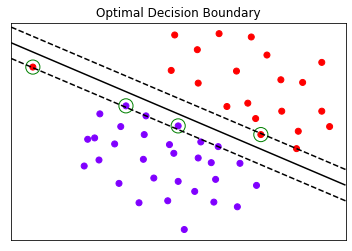

In [90]:
# Problem (1a)
def LinearSVM_Primal (X, y, C):
    # -------- INSERT YOUR CODE HERE -------- #
    start = time.time()
    if 0 in y:
        yt = (y.copy() - 0.5)*2
    else:
        yt = y.copy()
    w = cp.Variable((X.shape[1],1))
    b = cp.Variable()
    xi = cp.Variable((X.shape[0],1))
    yt = expand_dims(yt, 1)
    obj = cp.Minimize(0.5*cp.norm2(w) + C*cp.sum(xi))
    con = [cp.multiply(yt,(X * w+b))>=1-xi, xi >=0]
    prob = cp.Problem(obj, con)
    result = prob.solve()
    sol_time = time.time() - start
    return w.value, b.value, sol_time

# Compute the decision boundary
# -------- INSERT YOUR CODE HERE -------- # 
def decision_boundary(w, b, X, sv):
    plt.scatter(X[:,0],X[:,1],c=y,cmap = "rainbow")
    if sv is not None:
        plt.scatter(sv[:,0], sv[:,1], c="",marker='o', edgecolors='g', s=200)
    plt.xticks([])
    plt.yticks([])
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    axisx = linspace(xlim[0], xlim[1], 30)
    axisy = linspace(ylim[0], ylim[1], 30)
    axisy, axisx = meshgrid(axisy, axisx)
    xy = vstack([axisx.ravel(), axisy.ravel()]).T
    lev = dot(xy, w) + b
    lev = lev.reshape((30,30))
    ax.contour(axisx, axisy, lev, colors="k",levels=[-1,0,1],linestyles=["--","-","--"])
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_title("Optimal Decision Boundary")
    plt.show()

# Compute the optimal support vectors
# -------- INSERT YOUR CODE HERE -------- #
def compute_sv(w, b, X, y):
    if 0 in y:
        y = 2*y-1
    if len(w.shape) == 1:
        con = 1 - multiply(expand_dims(y, 1), dot(X, expand_dims(w,1)) + b)
    else:
        con = 1 - multiply(expand_dims(y, 1), dot(X, w) + b)
    sv = con >= 0
    # print(X.shape, sv.shape, y.shape)
    return X[squeeze(sv),:]

def LinearSVM_Primal_show(X, y):
    w, b, sol_time = LinearSVM_Primal(X.copy(),y.copy(),1)
    print("The solution time is:", sol_time)
    sv = compute_sv(w,b,X,y)
    print("The optimal support vectors are:")
    print(compute_sv(w,b,X,y))
    decision_boundary(w, b, X, sv)

LinearSVM_Primal_show(X, y)

The optimal support vectors are:
[[3.5772   2.856   ]
 [3.1048   3.0709  ]
 [1.9182   4.0534  ]
 [2.6555   3.5008  ]
 [3.0357   3.3165  ]
 [1.5841   3.3575  ]
 [2.0103   3.2039  ]
 [2.3099   2.9584  ]
 [2.8283   2.6309  ]
 [1.3191   3.5109  ]
 [2.5403   2.8867  ]
 [0.086405 4.1045  ]]


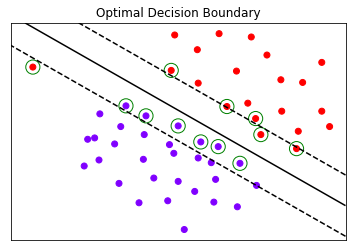

The optimal dual solution is:
w =  [1.40667281 2.13320243]
b =  -10.17444837986092
The solution time is: 0.0039520263671875


In [91]:
# Problem (1b)

def LinearSVM_Dual (X, y, C):
    n, p = X.shape
    # y = y.reshape(-1,1) * 1.
    if 0 in y:
        y  = 2*y - 1

    X_dash = y.reshape(-1,1) * 1. * X
    # Complete the following code:
    # cvxopt_solvers.qp(P, q, G, h, A, b)
    # objective:    (1/2) x^T P x + q^T x
    # constraints:  Gx < h
    #               Ax = b
    # example could be found here:
    # https://cvxopt.org/userguide/coneprog.html#quadratic-programming


    H = dot(X_dash , X_dash.T) * 1.
    #Converting into cvxopt format
    P = cvxopt_matrix(H)
    q = cvxopt_matrix(ones(n) * -1)
    G = cvxopt_matrix(vstack((diag(ones(n) * -1), identity(n))))
    h = cvxopt.matrix(hstack((zeros(n), ones(n) * C)))
    A = cvxopt_matrix(y, (1,n))
    b = cvxopt_matrix(0.0)

    cvxopt_solvers.options['show_progress'] = False
    cvxopt_solvers.options['abstol'] = 1e-10
    cvxopt_solvers.options['reltol'] = 1e-10
    cvxopt_solvers.options['feastol'] = 1e-10

    # -- INSERT YOUR CODE HERE -- #
    start = time.time()
    sol = cvxopt_solvers.qp(P, q, G, h, A, b)
    # -- INSERT YOUR CODE HERE -- #
    alphas = ravel(sol['x'])
    sol_time = time.time() - start
    return alphas, sol_time

    # Compute the optimal support vectors
    # -------- INSERT YOUR CODE HERE -------- #
def LinearSVM_Dual_show(X, y):
    xx = X.copy()
    yy = y.copy()
    alphas, soltime = LinearSVM_Dual(xx, yy, 1)
    yy = 2*y - 1
    w = sum(multiply(expand_dims(alphas,1),multiply(expand_dims(yy,1),xx)),axis=0)
    sv = alphas > 1e-5
    xx = xx[sv]
    print("The optimal support vectors are:")
    print(xx)
    # Compute the decision boundary
    # -------- INSERT YOUR CODE HERE -------- #
    yy = yy[sv]
    b = mean(yy - dot(xx, w))
    decision_boundary(w, b, X, xx)
    
    print("The optimal dual solution is:")
    print('w = ', w.flatten())
    print('b = ', b)
    print("The solution time is:", soltime)

LinearSVM_Dual_show(X, y)

In [92]:
# Problem (1d)
def Linearly_separable (X, y):
    # -------- INSERT YOUR CODE HERE -------- #
    # Output: sep = 1 if data linearly seperable
    #         sep = 0 if data not linearly seperable
    if 0 in y:
        yt = (y.copy() - 0.5)*2
    else:
        yt = y.copy()

    w = cp.Variable((X.shape[1],1))
    b = cp.Variable()
    yt = expand_dims(yt, 1)
    obj = cp.Minimize(0.5*cp.norm2(w))
    con = [cp.multiply(yt,(X * w+b))>=1]
    prob = cp.Problem(obj, con)
    result = prob.solve()
    if prob.status == "optimal":
        sep = 1
    else:
        sep = 0
    return sep

The optimal support vectors are:
[[2.2753   3.8589  ]
 [2.932    3.5519  ]
 [3.5772   2.856   ]
 [3.3814   3.4291  ]
 [3.1048   3.0709  ]
 [1.9182   4.0534  ]
 [2.6555   3.5008  ]
 [3.6002   3.1221  ]
 [3.0357   3.3165  ]
 [1.5841   3.3575  ]
 [2.0103   3.2039  ]
 [1.9527   2.7843  ]
 [2.2753   2.7127  ]
 [2.3099   2.9584  ]
 [2.8283   2.6309  ]
 [3.0473   2.2931  ]
 [1.8951   2.9174  ]
 [1.561    3.0709  ]
 [0.9735   3.3881  ]
 [1.25     3.1937  ]
 [1.3191   3.5109  ]
 [2.4482   2.6411  ]
 [2.5403   2.8867  ]
 [0.086405 4.1045  ]]


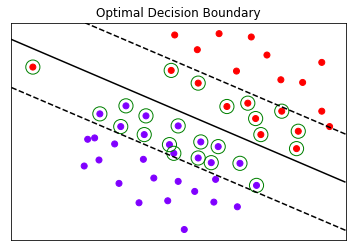

In [93]:
# Problem (1f)
def l2_norm_LinearSVM_Primal (X, y, C):
    # -------- INSERT YOUR CODE HERE -------- #
    start = time.time()
    if 0 in y:
        yt = 2*y - 1
    X_dash = yt.reshape(-1,1) * 1. * X
    w = cp.Variable((X.shape[1],1))
    b = cp.Variable()
    xi = cp.Variable((X.shape[0],1))
    yt = expand_dims(yt, 1)
    obj = cp.Minimize(0.5*cp.norm2(w) + 0.5*C*cp.norm2(xi))
    con = [cp.multiply(yt,(X * w+b))>=1-xi]
    prob = cp.Problem(obj, con)
    result = prob.solve()
    sol_time = time.time() - start
    return w.value, b.value, sol_time

    # Compute the optimal support vectors
    # -------- INSERT YOUR CODE HERE -------- #
def l2_norm_LinearSVM_Primal_show(X, y):
    w, b, sol_time = l2_norm_LinearSVM_Primal(X.copy(),y.copy(),1)
    sv = compute_sv(w, b, X, y)
    print("The optimal support vectors are:")
    print(sv)
    # Compute the decision boundary
    # -------- INSERT YOUR CODE HERE -------- #
    decision_boundary(w, b, X, sv)

l2_norm_LinearSVM_Primal_show(X, y)

The optimal support vectors are:
[[2.2753   3.8589  ]
 [2.932    3.5519  ]
 [3.5772   2.856   ]
 [3.1048   3.0709  ]
 [1.9182   4.0534  ]
 [2.6555   3.5008  ]
 [3.6002   3.1221  ]
 [3.0357   3.3165  ]
 [1.5841   3.3575  ]
 [2.0103   3.2039  ]
 [2.2753   2.7127  ]
 [2.3099   2.9584  ]
 [2.8283   2.6309  ]
 [3.0473   2.2931  ]
 [1.8951   2.9174  ]
 [1.561    3.0709  ]
 [0.9735   3.3881  ]
 [1.25     3.1937  ]
 [1.3191   3.5109  ]
 [2.4482   2.6411  ]
 [2.5403   2.8867  ]
 [0.086405 4.1045  ]]


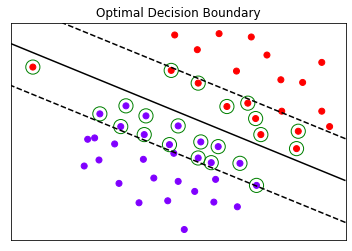

The optimal dual solution is:
w =  [0.73873771 1.56041503]
b =  -6.813998421657362


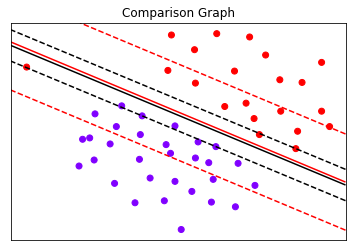

In [94]:
# Problem (1g)

def l2_norm_LinearSVM_Dual (X, y, C):
    zero_tol = 1e-7

    cvxopt_solvers.options['show_progress'] = False
    cvxopt_solvers.options['abstol'] = 1e-10
    cvxopt_solvers.options['reltol'] = 1e-10
    cvxopt_solvers.options['feastol'] = 1e-10

    # -------- INSERT YOUR CODE HERE -------- #
    n, p = X.shape
    if 0 in y:
        yt = (y.copy() - 0.5)*2
    else:
        yt = y.copy()
    X_dash = yt.reshape(-1,1) * 1. * X

    P = cvxopt_matrix(dot(X_dash , X_dash.T) * 1. + 1./C*eye(n))
    q = cvxopt_matrix(-ones((n, 1)))
    G = cvxopt_matrix(-eye(n))
    h = cvxopt_matrix(zeros(n))
    A = cvxopt_matrix(yt.reshape(1, -1))
    b = cvxopt_matrix(zeros(1))

    start = time.time()
    sol = cvxopt_solvers.qp(P, q, G, h, A, b)
    sol_time = time.time() - start
    alphas = ravel(sol['x'])

    return alphas, sol_time

    # Compute the optimal support vectors
    # -------- INSERT YOUR CODE HERE -------- #
def l2_LinearSVM_Dual_show(X, y):
    xx = X.copy()
    yy = y.copy()
    alphas, soltime = l2_norm_LinearSVM_Dual(xx, yy, 1)
    yy = 2*y - 1
    w = sum(multiply(expand_dims(alphas,1),multiply(expand_dims(yy,1),xx)),axis=0)
    sv = alphas > 1e-5
    xx = xx[sv]
    yy = yy[sv]
    b = mean(yy - dot(xx,w))
    print('The optimal support vectors are:')
    print(xx)
    # Compute the decision boundary
    # -------- INSERT YOUR CODE HERE -------- # 
    decision_boundary(w, b, X, xx)
    
    print("The optimal dual solution is:")
    print('w = ', w.flatten())
    print('b = ', b)

l2_LinearSVM_Dual_show(X,y)

# Problem (1h)

# Plot the decision boundaries and datapoints
# -------- INSERT YOUR CODE HERE -------- #
w1,b1,t1 = LinearSVM_Primal(X,y,1)
w2,b2,t2 = l2_norm_LinearSVM_Primal(X,y,1)
plt.scatter(X[:,0],X[:,1],c=y,cmap = "rainbow")
plt.xticks([])
plt.yticks([])
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()
axisx = linspace(xlim[0], xlim[1], 30)
axisy = linspace(ylim[0], ylim[1], 30)
axisy, axisx = meshgrid(axisy, axisx)
xy = vstack([axisx.ravel(), axisy.ravel()]).T
lev = dot(xy, w1) + b1
lev = lev.reshape((30,30))
ax.contour(axisx, axisy, lev, colors="k",levels=[-1,0,1],linestyles=["--","-","--"])
lev = dot(xy, w2) + b2
lev = lev.reshape((30,30))
ax.contour(axisx, axisy, lev, colors="r",levels=[-1,0,1],linestyles=["--","-","--"])
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_title("Comparison Graph")
plt.show()

## Problem 2

(2a) to (2b)

In [75]:
# Import libraries
from numpy import *
import pandas as pd
# Hint: consider using this funtion for (2a)
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn import preprocessing

import matplotlib.pylab as plt

In [76]:
# Import Data
data2 = pd.read_csv('prob2data.csv',header=None).values
X = data2[:,0:2]
y = data2[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 2020)

In [77]:
# Problem (2a)

def gaussian_kernal(sigma):
    def gaussian_kernel_sigma(x1, x2):
        # -------- INSERT YOUR CODE HERE -------- # 
        k = zeros((x1.shape[0],x2.shape[0]))
        simga2 = sigma**2*2
        for i in range(x1.shape[0]):
            for j in range(x2.shape[0]):
                k[i][j] = exp(-1*linalg.norm(x1[i,:] - x2[j,:],2)/simga2)
        return k
    return gaussian_kernel_sigma

The number of support vectors is: [306 382]
The prediction error ratio in test set is: 0.0


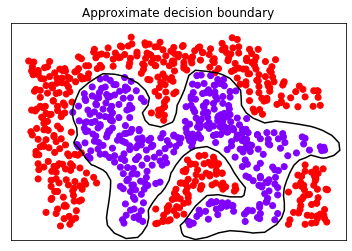

In [79]:
# Problem (2b)

kernel_SVM = SVC(C=1, kernel=gaussian_kernal(0.1))
# Compute # of optimal support vectors
# -- INSERT YOUR CODE HERE -- #
clf = kernel_SVM.fit(X_train, y_train)
print("The number of support vectors is:", clf.n_support_)

# Compute prediction error ratio in test set
# -- INSERT YOUR CODE HERE -- #
score = kernel_SVM.score(X_test, y_test)
print("The prediction error ratio in test set is:", 1 - score)
# Plot the decision boundary with all datapoints
# -- INSERT YOUR CODE HERE -- #
def decision_boundary_svc(X,y,clf):
    plt.scatter(X[:,0],X[:,1],c=y,cmap = "rainbow")
    plt.xticks([])
    plt.yticks([])
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    axisx = linspace(xlim[0], xlim[1], 30)
    axisy = linspace(ylim[0], ylim[1], 30)
    axisy, axisx = meshgrid(axisy, axisx)
    xy = vstack([axisx.ravel(), axisy.ravel()]).T
    lev = clf.decision_function(xy).reshape(axisx.shape)
    lev = lev.reshape((30,30))
    ax.contour(axisx, axisy, lev, colors="k",levels=[-1,0,1],linestyles=["--","-","--"])
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_title("Approximate decision boundary")
    plt.show()
    
decision_boundary_svc(X.copy(),y.copy(),clf)

(2c) - (2e)

In [80]:
# Import data for (2c) - (2e)
data3 = pd.read_csv('votes.csv')
X = data3[['white','black','poverty','density','bachelor','highschool','age65plus','income','age18under','population2014']]
X = X.values
X = preprocessing.scale(X)


In [81]:
# Problem (2c)
# y = # -- INSERT YOUR CODE HERE -- #
trump = data3['trump']
clinton = data3['clinton']
y = array([1 if t > c else 0 for t,c in zip(trump, clinton)])

In [82]:
# Train / test split for (2d) - (2e)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 2020)

In [83]:
# Problem (2d)

# You may use SVC from sklearn.svm
# -------- INSERT YOUR CODE HERE -------- #
C = 10
max_iter = 1e6
kernel_degree = [1,2,3,4,5]
for degree in kernel_degree:
    clf = SVC(C = C, kernel='poly',degree=degree,max_iter=max_iter)

# Compute # of optimal support vectors
# -------- INSERT YOUR CODE HERE -------- #
    clf.fit(X_train, y_train)
    print("degree:", degree)
    print("The number of support vectors is:", clf.n_support_)
# Compute prediction error ratio in test set
# -------- INSERT YOUR CODE HERE -------- #
    print("error ration in X_train:", 1 - clf.score(X_train,y_train))
    print("error ration in X_test:", 1 - clf.score(X_test, y_test))

E:\Anaconda\Anaconda\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
E:\Anaconda\Anaconda\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


degree: 1
The number of support vectors is: [237 239]
error ration in X_train: 0.08723599632690537
error ration in X_test: 0.08351177730192716
degree: 2
The number of support vectors is: [204 214]
error ration in X_train: 0.06703397612488526
error ration in X_test: 0.06852248394004279


E:\Anaconda\Anaconda\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
E:\Anaconda\Anaconda\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


degree: 3
The number of support vectors is: [181 194]
error ration in X_train: 0.05555555555555558
error ration in X_test: 0.06423982869379019
degree: 4
The number of support vectors is: [173 203]
error ration in X_train: 0.05004591368227729
error ration in X_test: 0.07387580299785867


E:\Anaconda\Anaconda\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


degree: 5
The number of support vectors is: [175 211]
error ration in X_train: 0.03994490358126723
error ration in X_test: 0.07815845824411138
